# Comparison of velocities between EM and VI model

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definitions

In [5]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")

In [6]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

## Data loading

In [7]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [8]:
palette = dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))

## Data preprocessing

In [9]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata)

bdata = adata.copy()

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Model fitting

In [10]:
adata = sc.read(DATA_DIR / 'pancreas' / 'adata_after_scvelo_pipeline.h5ad')

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:56<00:00,  4.29it/s, loss=-2.65e+03, v_num=1]


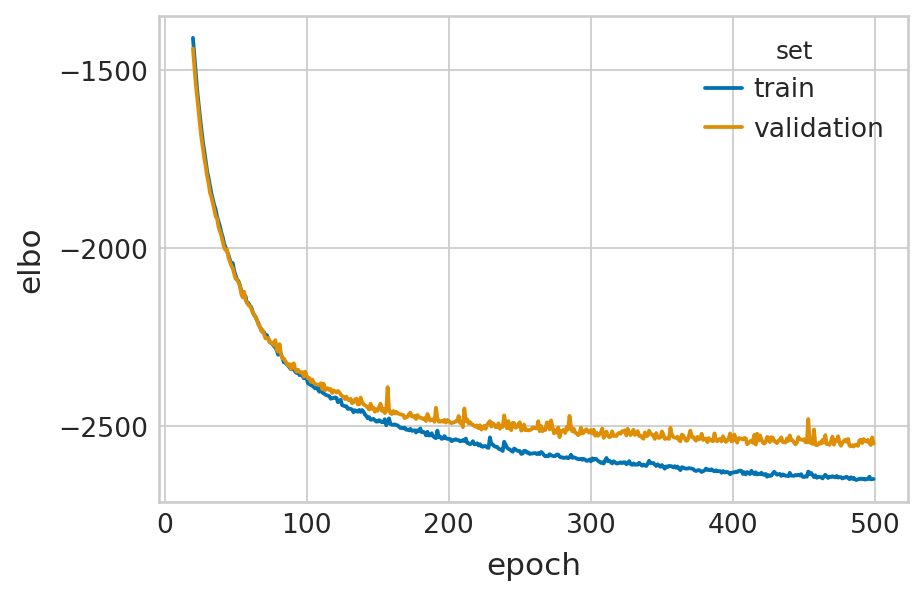

In [11]:
velovi_vae = fit_velovi(bdata)

## Evaluate

### Gene comparison

In [12]:
genes = ['Sulf2', 'Top2a']

for gene in genes:
    print(f"Correlation {gene}: {np.corrcoef(adata.to_df('velocity')[gene], bdata.to_df('velocities_velovi')[gene])[0, 1]}")

Correlation Sulf2: 0.6004494854557519
Correlation Top2a: 0.1308248586326778


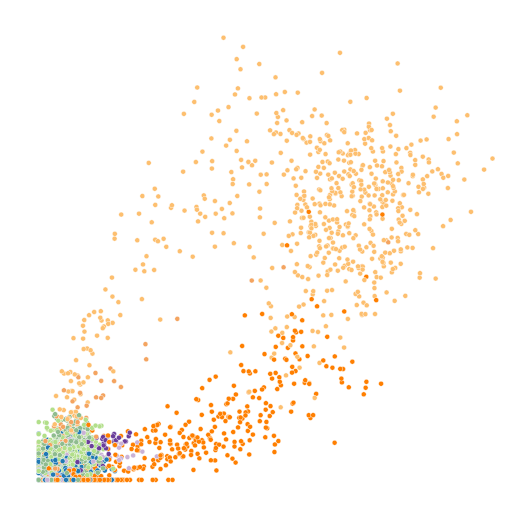

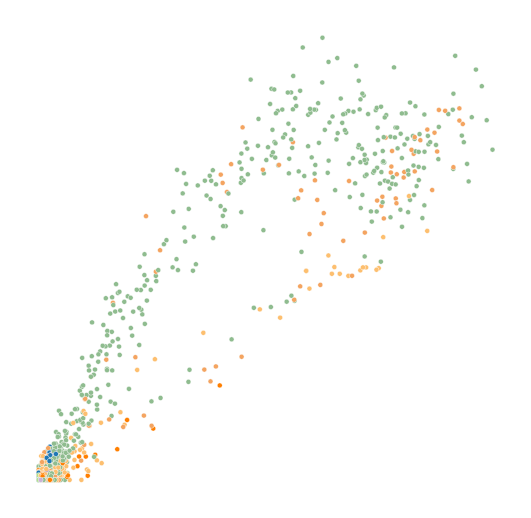

In [13]:
for gene in genes:
    with mplscience.style_context():
        fig, ax = plt.subplots(figsize=(4, 4))

        df = pd.DataFrame()
        df["Unspliced"] = adata.to_df("Mu")[gene]
        df["Spliced"] = bdata.to_df("Ms")[gene]
        df["clusters"] = adata.obs.clusters
        sns.scatterplot(
            x="Spliced",
            y="Unspliced",
            data=df,
            hue="clusters",
            s=5,
            ax=ax,
            palette=palette,
        );

        ax.axis('off')
        ax.get_legend().remove()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'comparison' / f'phase_portrait_pancreas_{gene}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

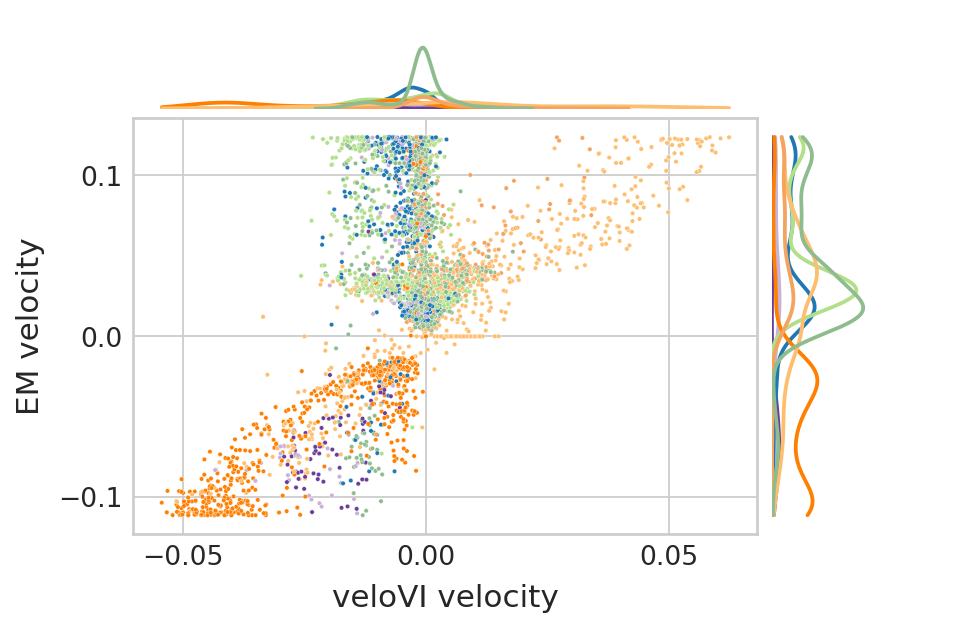

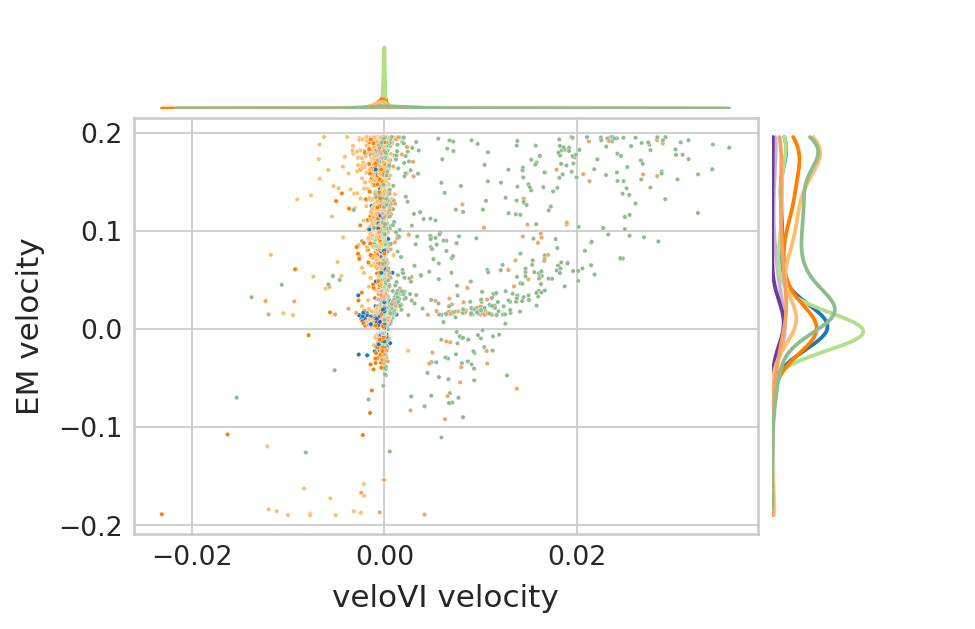

In [14]:
for gene in genes:
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.axis('off')
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.015
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.1]
        rect_histy = [left + width + spacing, bottom, 0.1, height]

        ax = fig.add_axes(rect_scatter)
        ax_histx = fig.add_axes(rect_histx, sharex=ax)
        ax_histy = fig.add_axes(rect_histy, sharey=ax)
        ax_histx.axis("off")
        ax_histy.axis("off")

        df = pd.DataFrame()
        df["EM velocity"] = adata.to_df("velocity")[gene]
        df["veloVI velocity"] = bdata.to_df("velocities_velovi")[gene]
        df["clusters"] = adata.obs.clusters
        clipy = (df["EM velocity"].min(), df["EM velocity"].max())
        clipx = (df["veloVI velocity"].min(), df["veloVI velocity"].max())
        sns.kdeplot(
            data=df,
            y="EM velocity",
            hue="clusters",
            ax=ax_histy,
            legend=False,
            clip=clipy,
            palette=palette,
        )
        sns.kdeplot(
            data=df,
            x="veloVI velocity",
            hue="clusters",
            ax=ax_histx,
            legend=False,
            clip=clipx,
            palette=palette,
        )
        sns.scatterplot(
            y="EM velocity",
            x="veloVI velocity",
            data=df,
            hue="clusters",
            s=4,
            palette=palette,
            ax=ax,
            legend=False
        )

        
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'comparison' / f'velocity_comparison_pancreas_{gene}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )